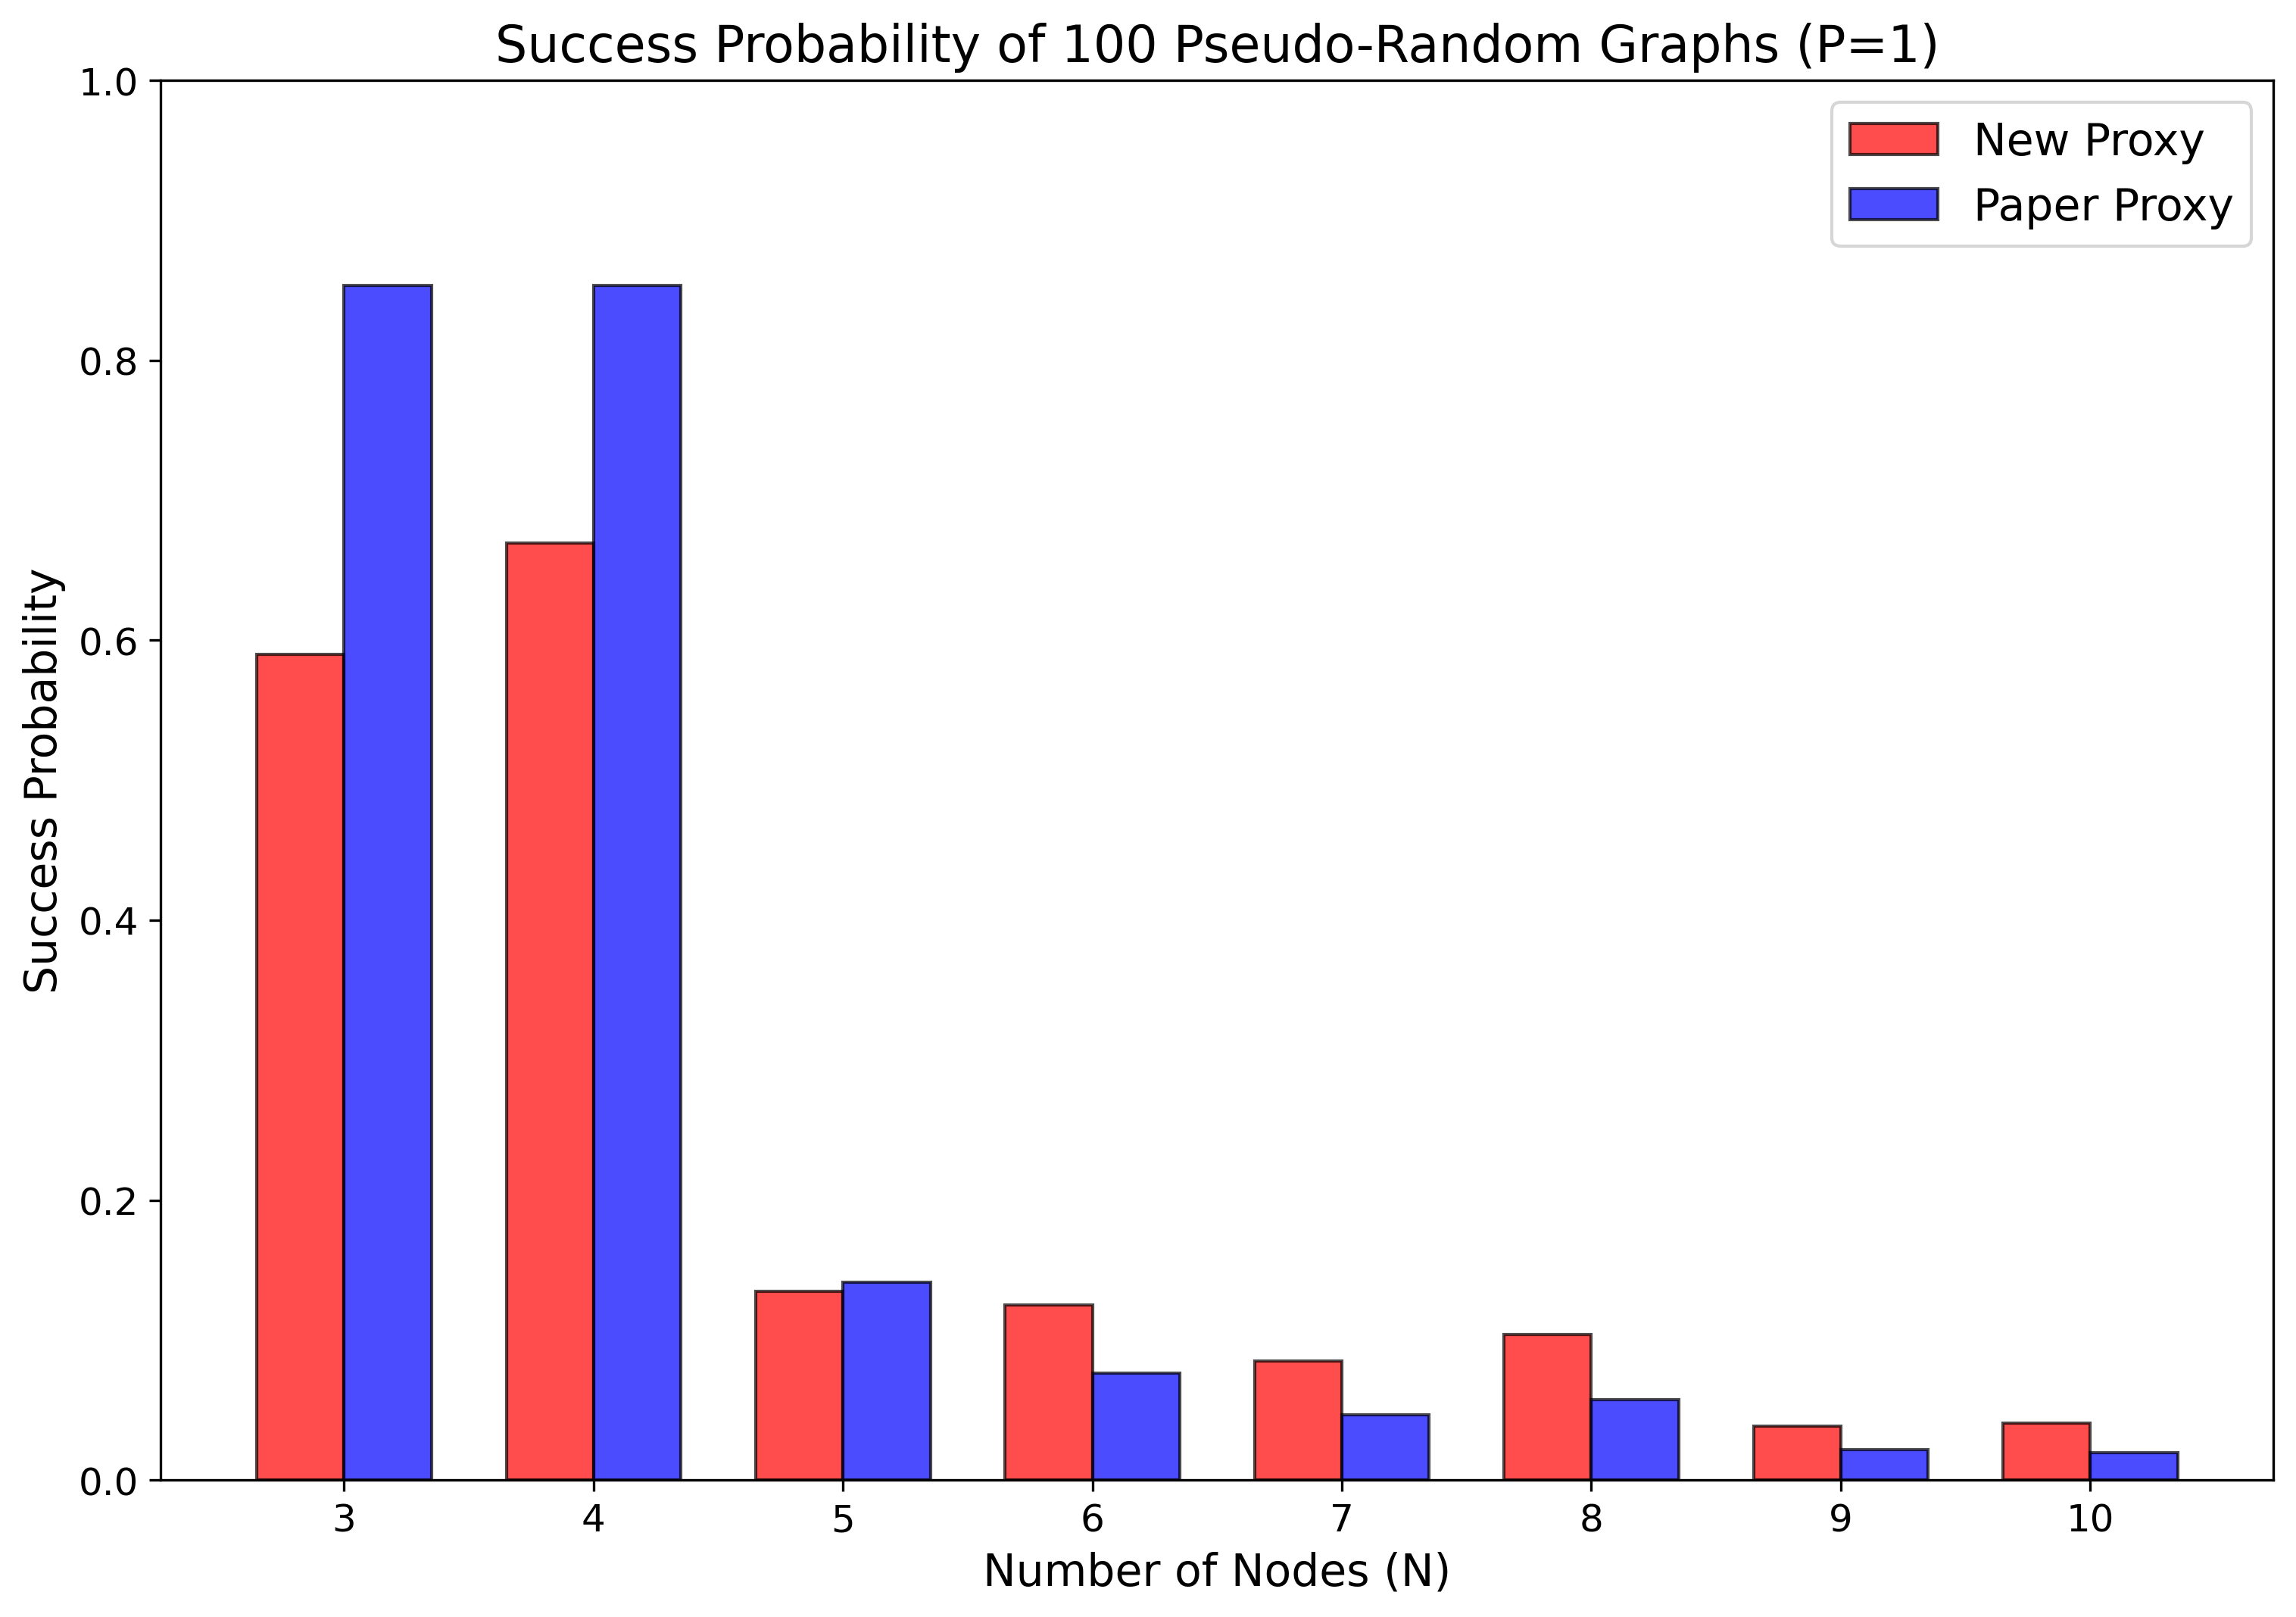

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_overlap, get_simulator
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp
import os  #データ保存に必要

# QAOAの層数
p = 1

#seedの設定
seed = 0

# 結果を格納するリスト
success_probs_new_proxy = []
success_probs_paper_proxy = []

#Gをランダムに生成
def erdos_reyni(num_verts: int, num_edges: int, seed: int | None = None) -> nx.Graph:
    # num_verts: グラフの頂点の数
    # num_edges: グラフのエッジの数
    # seed: 乱数生成のシード（省略可能）

    # num_verts個の頂点を持つ完全グラフを生成します
    G = nx.complete_graph(num_verts)

    # 乱数シードが指定されていれば、そのシードで乱数を初期化します
    if (seed is not None):
        np.random.seed(seed)

    # 完全グラフのエッジのリストを取得し、NumPy配列に変換します
    edges = np.array(G.edges())

    # エッジのインデックスからnum_edges本のエッジを除去するためのランダムなインデックスを選択します
    indices = np.random.choice(a=len(edges), size=len(edges) - num_edges, replace=False)

    # 選択したインデックスのエッジをグラフから削除します
    for index in indices:
        G.remove_edge(edges[index][0], edges[index][1])

    # 最終的なグラフを返します
    return G

#試行回数
T = 100

# 保存先ディレクトリを指定
save_dir = f"data_for_graphs_success_probs_P={p}_T={T}"
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成する

# Nを3から10まで変化させて計算
for N in range(3, 11):

    for i in range(T):
        # 各Nについて10回の試行の成功確率を格納するリスト
        success_probs_new_proxy_i = []
        success_probs_paper_proxy_i = []

        # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
        G = nx.erdos_renyi_graph(N, 0.5)

        # グラフからIsingモデルの項を取得
        ising_model = mc.get_maxcut_terms(G)

        # シミュレーターの初期化
        sim = get_simulator(N, ising_model)

        # 初期のgammaとbetaを設定（全て0.1）
        init_gamma, init_beta = np.full((2, p), 0.1)

        # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
        result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]

        # 得られたgammaとbetaでオーバーラップを計算
        overlap = get_overlap(N, ising_model, gamma, beta, simulator_name='auto')

        # 成功確率（オーバーラップ）を計算
        success_prob = overlap

        # 結果をリストに追加
        success_probs_new_proxy_i.append(success_prob)

        np.save(f"data_for_graphs_success_probs_P={p}_T={T}/data_for_success_probs_new_proxy_N={N}_G{i}.npy", success_prob)

        #############

         # グラフからIsingモデルの項を取得
        ising_model = mc.get_maxcut_terms(G)

        # シミュレーターの初期化
        sim = get_simulator(N, ising_model)

        # 初期のgammaとbetaを設定（全て0.1）
        init_gamma, init_beta = np.full((2, p), 0.1)

        # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
        result_paper = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result_paper["gamma"]
        beta = result_paper["beta"]

        # 得られたgammaとbetaでオーバーラップを計算
        overlap = get_overlap(N, ising_model, gamma, beta, simulator_name='auto')

        # 成功確率（オーバーラップ）を計算
        success_prob = overlap

        # 結果をリストに追加
        success_probs_paper_proxy_i.append(success_prob)

        np.save(f"data_for_graphs_success_probs_P={p}_T={T}/data_for_success_probs_paper_proxy_N={N}_G{i}.npy", success_prob)

    # 各Nに対して10回の試行の平均を計算
    success_probs_new_proxy.append(np.mean(success_probs_new_proxy_i))
    success_probs_paper_proxy.append(np.mean(success_probs_paper_proxy_i))

# グラフのサイズと解像度の設定（figsizeとdpiを調整）
plt.figure(figsize=(12, 8), dpi=300)

# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 11)  #x軸のインデックス

# 新しいプロキシの棒グラフ（枠を黒色に設定）
plt.bar(index - bar_width / 2, success_probs_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy', edgecolor='black')

# 論文プロキシの棒グラフ（枠を黒色に設定）
plt.bar(index + bar_width / 2, success_probs_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy', edgecolor='black')

# グラフの設定
plt.xlabel('Number of Nodes (N)', fontsize=14)
plt.ylabel('Success Probability', fontsize=14)
plt.title(f'Success Probability of {T} Pseudo-Random Graphs (P={p})', fontsize=16)
plt.xticks(index, fontsize=12)  # x軸の目盛りのサイズ
plt.yticks(fontsize=12)  # y軸の目盛りのサイズ
plt.ylim([0, 1])  # 縦軸の範囲を設定
plt.legend(prop={'size': 14})

# グラフをファイルとして保存
plt.savefig(f"{save_dir}/Success Probability of {T} Pseudo-Random Graphs (P={p}).png", format='png', bbox_inches='tight')

# グラフの表示
plt.show()

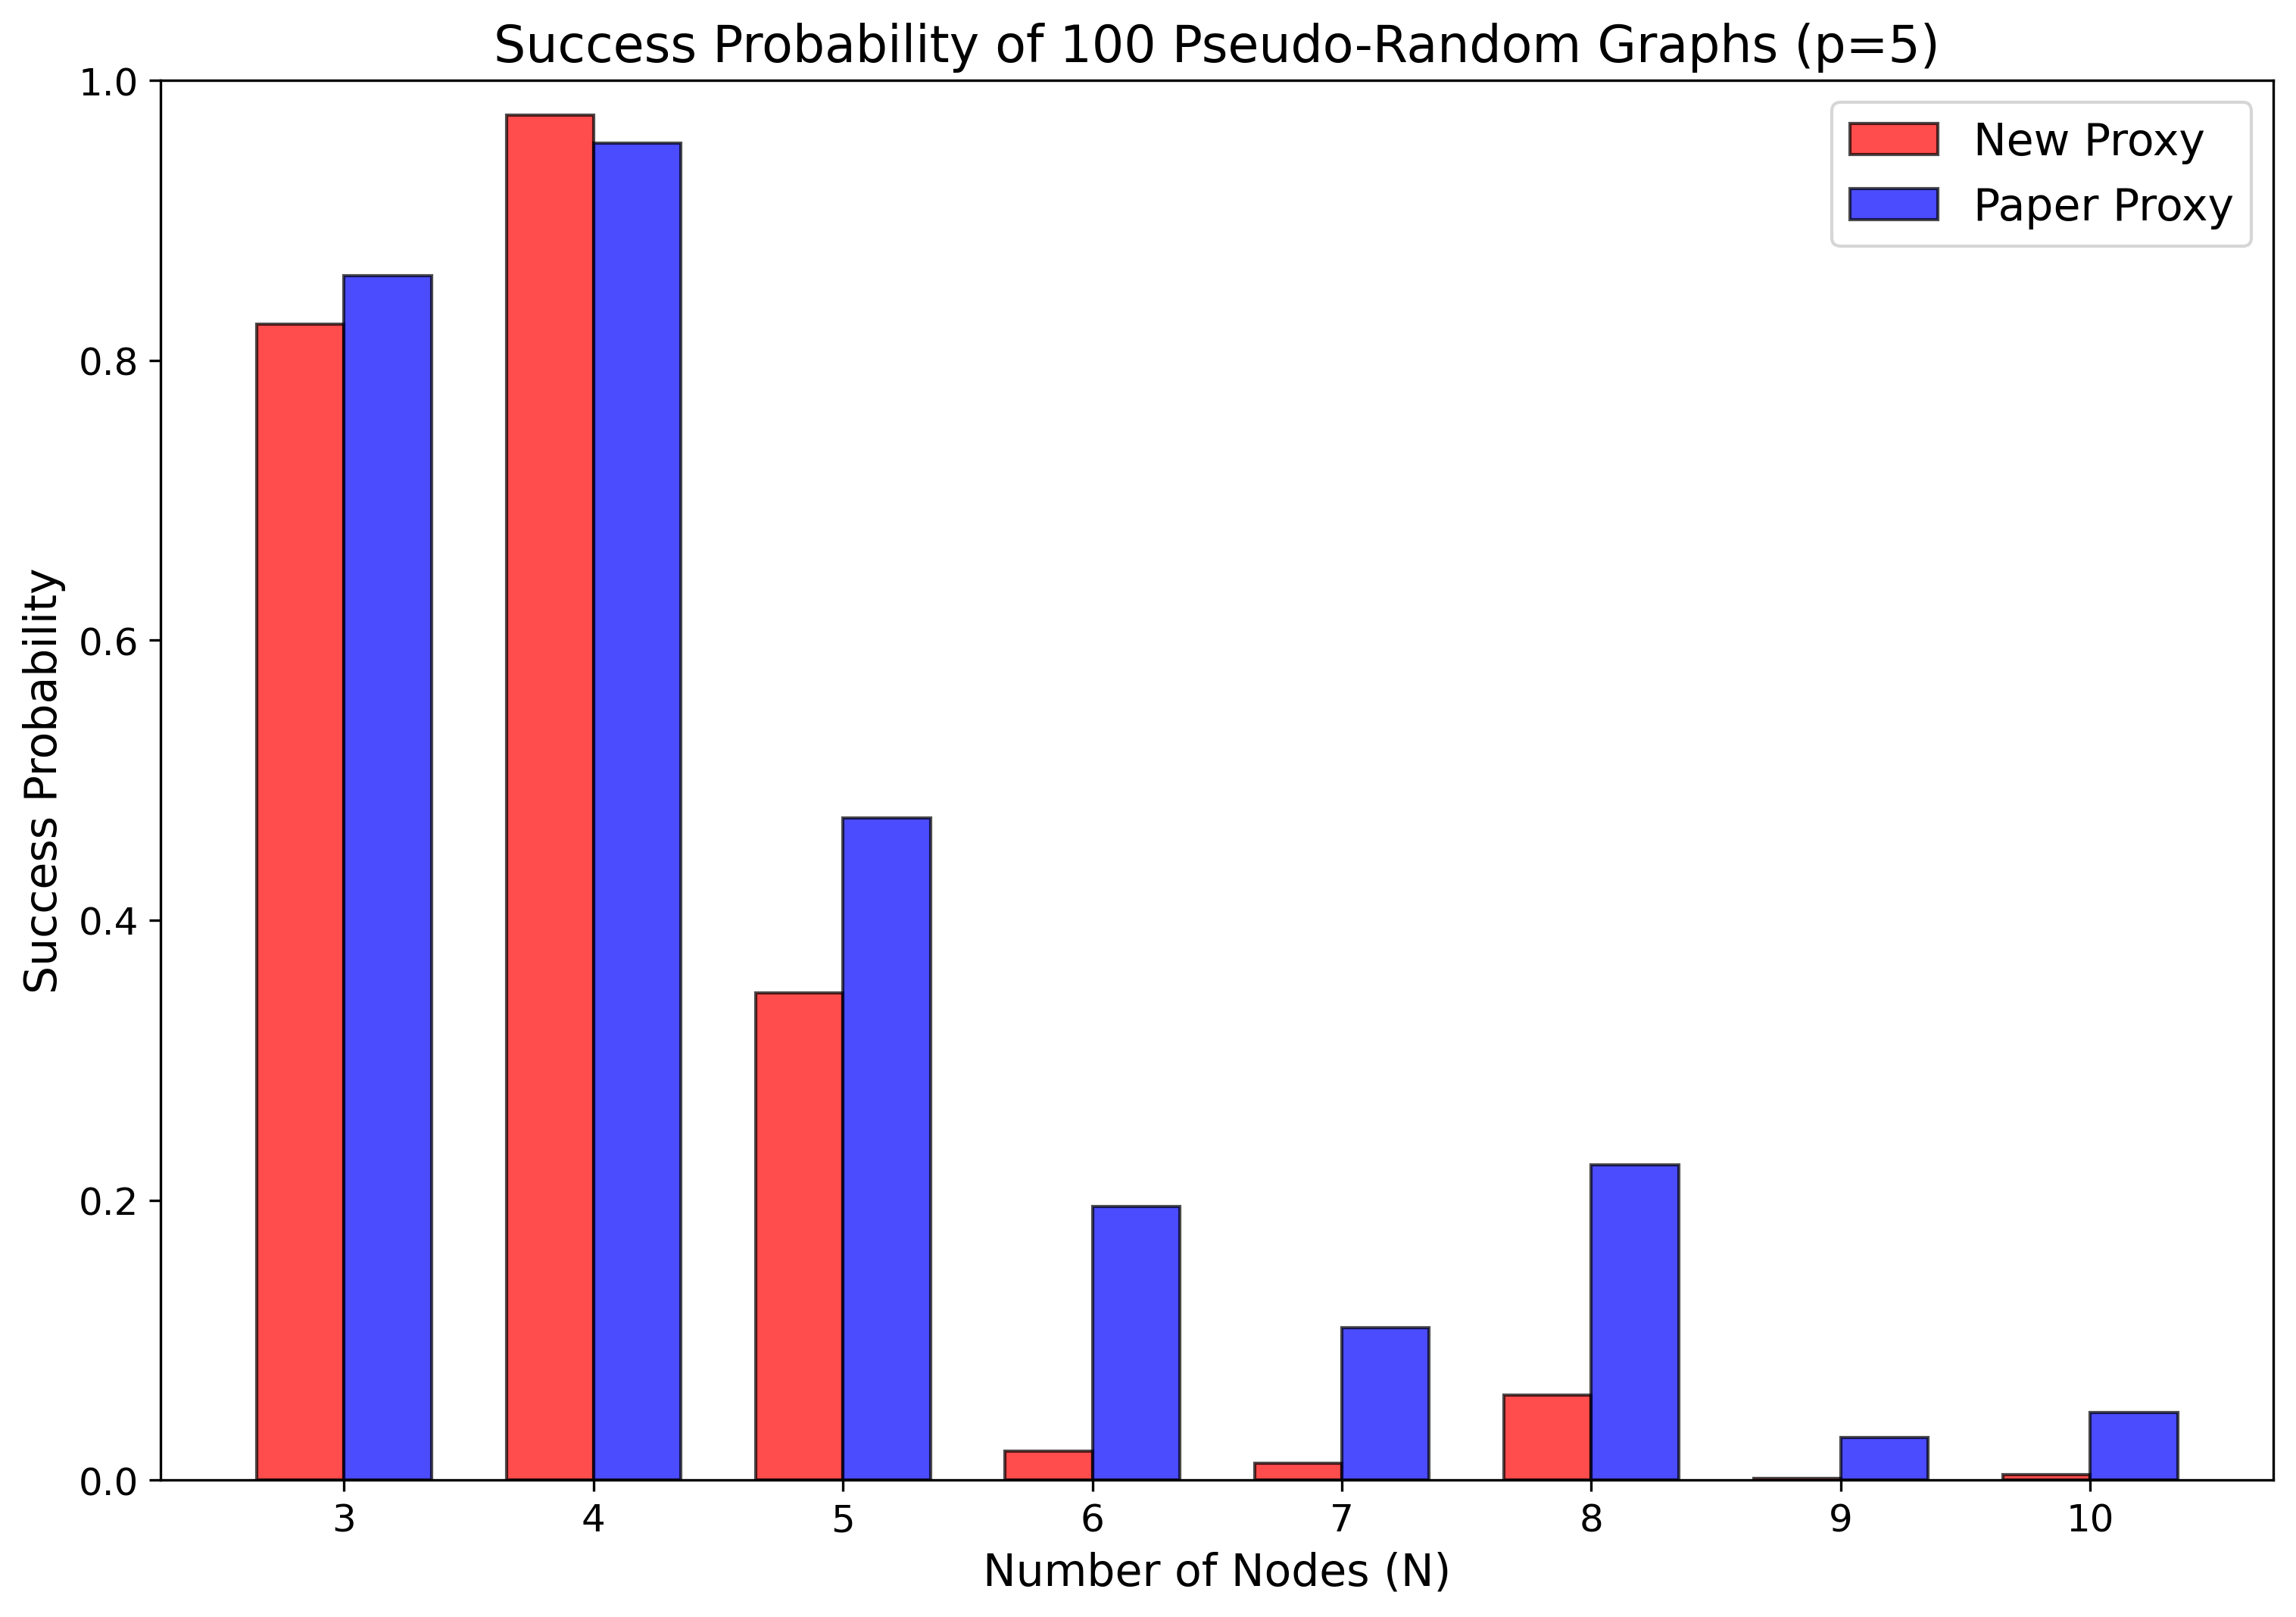

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_overlap, get_simulator
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp
import os  #データ保存に必要

# QAOAの層数
p = 5

#seedの設定
seed = 0

# 結果を格納するリスト
success_probs_new_proxy = []
success_probs_paper_proxy = []

#Gをランダムに生成
def erdos_reyni(num_verts: int, num_edges: int, seed: int | None = None) -> nx.Graph:
    # num_verts: グラフの頂点の数
    # num_edges: グラフのエッジの数
    # seed: 乱数生成のシード（省略可能）

    # num_verts個の頂点を持つ完全グラフを生成します
    G = nx.complete_graph(num_verts)

    # 乱数シードが指定されていれば、そのシードで乱数を初期化します
    if (seed is not None):
        np.random.seed(seed)

    # 完全グラフのエッジのリストを取得し、NumPy配列に変換します
    edges = np.array(G.edges())

    # エッジのインデックスからnum_edges本のエッジを除去するためのランダムなインデックスを選択します
    indices = np.random.choice(a=len(edges), size=len(edges) - num_edges, replace=False)

    # 選択したインデックスのエッジをグラフから削除します
    for index in indices:
        G.remove_edge(edges[index][0], edges[index][1])

    # 最終的なグラフを返します
    return G

#試行回数
T = 100

# 保存先ディレクトリを指定
save_dir = f"data_for_graphs_success_probs_P={p}_T={T}"
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成する

# Nを3から10まで変化させて計算
for N in range(3, 11):

    for i in range(T):
        # 各Nについて10回の試行の成功確率を格納するリスト
        success_probs_new_proxy_i = []
        success_probs_paper_proxy_i = []

        # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
        G = nx.erdos_renyi_graph(N, 0.5)

        # グラフからIsingモデルの項を取得
        ising_model = mc.get_maxcut_terms(G)

        # シミュレーターの初期化
        sim = get_simulator(N, ising_model)

        # 初期のgammaとbetaを設定（全て0.1）
        init_gamma, init_beta = np.full((2, p), 0.1)

        # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
        result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]

        # 得られたgammaとbetaでオーバーラップを計算
        overlap = get_overlap(N, ising_model, gamma, beta, simulator_name='auto')

        # 成功確率（オーバーラップ）を計算
        success_prob = overlap

        # 結果をリストに追加
        success_probs_new_proxy_i.append(success_prob)

        np.save(f"data_for_graphs_success_probs_P={p}_T={T}/data_for_success_probs_new_proxy_N={N}_G{i}.npy", success_prob)

        #############

         # グラフからIsingモデルの項を取得
        ising_model = mc.get_maxcut_terms(G)

        # シミュレーターの初期化
        sim = get_simulator(N, ising_model)

        # 初期のgammaとbetaを設定（全て0.1）
        init_gamma, init_beta = np.full((2, p), 0.1)

        # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
        result_paper = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result_paper["gamma"]
        beta = result_paper["beta"]

        # 得られたgammaとbetaでオーバーラップを計算
        overlap = get_overlap(N, ising_model, gamma, beta, simulator_name='auto')

        # 成功確率（オーバーラップ）を計算
        success_prob = overlap

        # 結果をリストに追加
        success_probs_paper_proxy_i.append(success_prob)

        np.save(f"data_for_graphs_success_probs_P={p}_T={T}/data_for_success_probs_paper_proxy_N={N}_G{i}.npy", success_prob)

    # 各Nに対して10回の試行の平均を計算
    success_probs_new_proxy.append(np.mean(success_probs_new_proxy_i))
    success_probs_paper_proxy.append(np.mean(success_probs_paper_proxy_i))

# グラフのサイズと解像度の設定（figsizeとdpiを調整）
plt.figure(figsize=(12, 8), dpi=300)

# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 11)  # x軸のインデックス

# 新しいプロキシの棒グラフ（枠を黒色に設定）
plt.bar(index - bar_width / 2, success_probs_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy', edgecolor='black')

# 論文プロキシの棒グラフ（枠を黒色に設定）
plt.bar(index + bar_width / 2, success_probs_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy', edgecolor='black')

# グラフの設定
plt.xlabel('Number of Nodes (N)', fontsize=14)
plt.ylabel('Success Probability', fontsize=14)
plt.title(f'Success Probability of {T} Pseudo-Random Graphs (p={p})', fontsize=16)
plt.xticks(index, fontsize=12)  # x軸の目盛りのサイズ
plt.yticks(fontsize=12)  # y軸の目盛りのサイズ
plt.ylim([0, 1])  # 縦軸の範囲を設定
plt.legend(prop={'size': 14})

# グラフをファイルとして保存
plt.savefig(f"{save_dir}/Success Probability of {T} Pseudo-Random Graphs (p={p}).png", format='png', bbox_inches='tight')

# グラフの表示
plt.show()